# Analyzing the surface pattern of The Great Blue Norther of November 11, 1911

On November 11, 1911 (11/11/11!), Oklahoma City, OK set a daily maximum and daily minimum temperature on the first day! Let's take a closer look at the estimated surface weather in the days surrounding the event as depicted by the 20th century reanalysis version 3

In [20]:
#set up environment
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, HTML
import pyproj
import os
os.environ['PROJ_LIB'] = r'/home/khoogewi/.conda/envs/cent7/5.3.1-py37/py37/share/proj'
plt.rcParams['animation.ffmpeg_path'] = '/home/khoogewi/.conda/envs/cent7/5.3.1-py37/py37/bin/ffmpeg'
from mpl_toolkits.basemap import Basemap
import numpy as np
import datetime
import pandas as pd
import seaborn as sns
import pytz
from netCDF4 import Dataset,num2date
import xarray as xr
%matplotlib inline

In [21]:
start_date = '19111108'
end_date = '19111114'

dates = pd.date_range(start_date,end_date,freq='3H')


def drawmap(ax,map,x,y,tvar,pvar,uvar,vvar,tbounds,title):
    
    ax.set_title(title, fontsize=14)
    map.ax = ax
    map.drawcountries()
    map.drawcoastlines()
    map.drawstates()
    # draw parallels and meridians.
    map.drawparallels(np.arange(-90.,91.,20.))
    map.drawmeridians(np.arange(-180.,181.,10.))
    map.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0])
    cs = map.contourf(x,y,tvar,vmin=tbounds.min(),vmax=tbounds.max(),cmap=plt.get_cmap('RdYlBu_r',lut=len(tbounds)+1),levels=tbounds,ax=ax,extend='both')
    hc = map.contour(x,y,pvar,levels=np.arange(980,1050,4),colors='k',linewidths=1)
    hc.clabel(inline=True,fmt='%d',fontsize='xx-small')
    ax.barbs(x[::3,::3],y[::3,::3],uvar[::3,::3],vvar[::3,::3],length=5)
    return cs,hc
    
def myanimate(i,ax,map,x,y,tvar,pvar,uvar,vvar,bounds,timevar):
    ax.clear()
    ncfill,nc1 = drawmap(ax,map,x,y,tvar[i,:,:],pvar[i,:,:],uvar[i,:,:],vvar[i,:,:],bounds,'20CRv3 2m T, MSLP, 10m Winds: {}Z'.format(timevar[i].strftime('%Y/%m/%d %H')) ) 

    return ncfill, nc1

FFMpegWriter = animation.writers['ffmpeg']
metadata = dict(title='20CRv3 from {} {:02d}Z'.format(start_date,dates[0].hour), artist='Carpentry@UIO',
                comment='Movie for 20CRv3 from {} {:02d}Z'.format(start_date,dates[0].hour))
writer = FFMpegWriter(fps=20, metadata=metadata)

year = np.unique(dates.year)[0]
if year < 1981:
    prefix = 'SI'
else:
    prefix = 'MO'
    
#paths to opendap files
'''
t2_file = 'https://psl.noaa.gov//thredds/dodsC/Datasets/20thC_ReanV3/2m{}/air.2m.{}.nc'.format(prefix,year)
mslp_file = 'https://psl.noaa.gov//thredds/dodsC/Datasets/20thC_ReanV3/misc{}/prmsl.2m.{}.nc'.format(prefix,year)
u10_file = 'https://psl.noaa.gov//thredds/dodsC/Datasets/20thC_ReanV3/10m{}/uwnd.10m.{}.nc'.format(prefix,year)
v10_file = 'https://psl.noaa.gov//thredds/dodsC/Datasets/20thC_ReanV3/10m{}/vwnd.10m.{}.nc'.format(prefix,year)
precip_file = 'https://psl.noaa.gov//thredds/dodsC/Datasets/20thC_ReanV3/accums{}/apcp.{}.nc'.format(prefix,year)
'''
t2_file = 'air.2m.subset.{}.nc'.format(year)
mslp_file = 'prmsl.subset.{}.nc'.format(year)
u10_file = 'uwnd.10m.subset.{}.nc'.format(year)
v10_file = 'vwnd.10m.subset.{}.nc'.format(year)


minlat = 20
maxlat = 60
minlon = -140
maxlon = -55

# I have the files stored locally to speed up reading
nc0 = Dataset(os.path.basename(t2_file),'r')
timevar = nc0.variables['time']
tunit = timevar.units
times1 = num2date(timevar[:],units=tunit)
timewhere = np.where((times1>=dates[0])&(times1<=dates[-1]))[0]
times = times1[timewhere]
lat = nc0.variables['lat'][:]
lon = nc0.variables['lon'][:]
lon[lon>180.] = lon[lon>180.]-360.
lons,lats = np.meshgrid(lon,lat)
t2m = nc0.variables['air'][timewhere,:,:] 
t2m = (t2m - 273.15) * 9./5. + 32. #convert to Fahrenheit
nc0.close()

nc1 = Dataset(mslp_file,'r')
pmsl = nc1.variables['prmsl'][timewhere,:,:]*0.01 #convert to hPa
nc1.close()

nc2 = Dataset(u10_file,'r')
uwnd = nc2.variables['uwnd'][timewhere,:,:]
nc2.close()

nc3 = Dataset(v10_file,'r')
vwnd = nc3.variables['vwnd'][timewhere,:,:]
nc3.close()

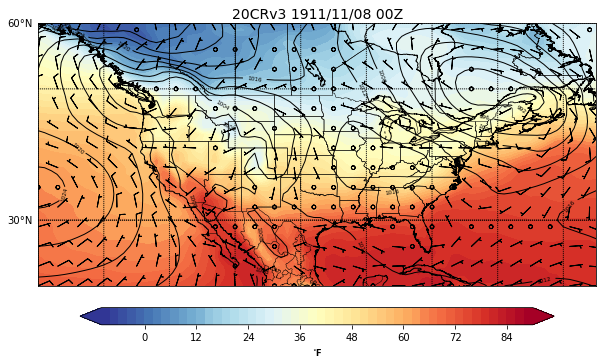

In [22]:
m = Basemap(projection='cyl',llcrnrlat=minlat,urcrnrlat=maxlat,\
            llcrnrlon=minlon,urcrnrlon=maxlon,resolution='i',area_thresh=10000)
x,y = m(lons,lats)
tbounds = np.arange(-10,91,2)
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,8))

tplot,tcon = drawmap(ax,m,x,y,t2m[0,:,:],pmsl[0,:,:],uwnd[0,:,:],vwnd[0,:,:],tbounds,'20CRv3 {}Z'.format(dates[0].strftime('%Y/%m/%d %H')))

colbar = fig.colorbar(tplot,orientation='horizontal',ax=ax,shrink=0.85,pad=0.05,aspect=25,extend='both',use_gridspec=False)
colbar.set_label('$^{\circ}$F',fontsize='small',weight='bold')
colbar.ax.tick_params(labelsize=10)

# Animate

In [23]:
ani = animation.FuncAnimation(fig,myanimate,frames=np.arange(len(times)), 
    fargs=(ax,m,x,y,t2m,pmsl,uwnd,vwnd,tbounds,times),interval=350)
#ani.save("writer_20CRv3_{}.mp4".format(start_date))

HTML(ani.to_html5_video())


On November 11, 1911 (11/11/11!), Oklahoma City, OK set a daily maximum and daily minimum temperature on the first day! Let's take a closer look

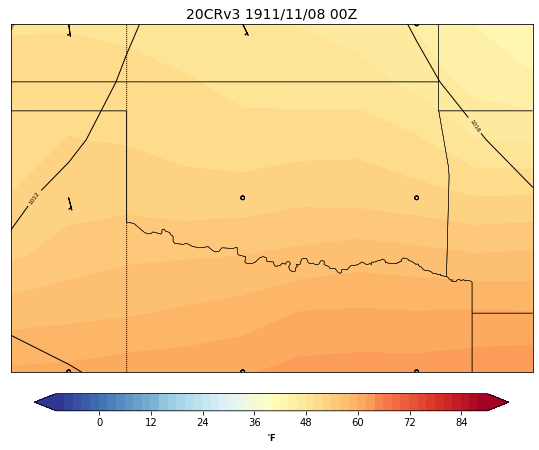

In [24]:
minlat = 32
maxlat = 38
minlon = -102
maxlon = -93

m2 = Basemap(projection='cyl',llcrnrlat=minlat,urcrnrlat=maxlat,\
            llcrnrlon=minlon,urcrnrlon=maxlon,resolution='i',area_thresh=10000)
x2,y2 = m2(lons,lats)
tbounds = np.arange(-10,91,2)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,8))

tplot,tcon = drawmap(ax,m2,x2,y2,t2m[0,:,:],pmsl[0,:,:],uwnd[0,:,:],vwnd[0,:,:],tbounds,'20CRv3 {}Z'.format(dates[0].strftime('%Y/%m/%d %H')))

colbar = fig.colorbar(tplot,orientation='horizontal',ax=ax,shrink=0.85,pad=0.05,aspect=25,extend='both',use_gridspec=False)
colbar.set_label('$^{\circ}$F',fontsize='small',weight='bold')
colbar.ax.tick_params(labelsize=10)


In [27]:
ani2 = animation.FuncAnimation(fig,myanimate,frames=np.arange(len(times)), 
    fargs=(ax,m2,x2,y2,t2m,pmsl,uwnd,vwnd,tbounds,times),interval=300)
#ani.save("writer_20CRv3_{}.mp4".format(start_date))
HTML(ani2.to_html5_video())
